## ASSIGNMENT 3 : Linear and Logistic regression and LDA using TensorFlow

# 1. Data Loading and Preparation:
1) Import necessary libraries: OS, Pandas, NumPy, and TensorFlow.

2) Load the provided CSV file into a Pandas DataFrame.

3) Analyze the data and handle any missing values or outliers.

In [83]:
!pip install scikeras[tensorflow]      # gpu compute platform
!pip install scikeras[tensorflow-cpu]  # cpu

In [84]:
import os, pandas as pd, numpy as np, tensorflow as tf, seaborn as sns
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
data = pd.read_csv('/content/Admission_Predict_A3.csv')

In [85]:
desc_stats = data.describe()
desc_stats.loc['median'] = data.median(numeric_only=True)
desc_stats = desc_stats.transpose()
print("Descriptive statistics:")
print(desc_stats)

Descriptive statistics:
                   count       mean         std     min       25%     50%  \
Serial No.         500.0  250.50000  144.481833    1.00  125.7500  250.50   
GRE Score          500.0  316.47200   11.295148  290.00  308.0000  317.00   
TOEFL Score        500.0  107.19200    6.081868   92.00  103.0000  107.00   
University Rating  500.0    3.11400    1.143512    1.00    2.0000    3.00   
SOP                500.0    3.37400    0.991004    1.00    2.5000    3.50   
LOR                500.0    3.48400    0.925450    1.00    3.0000    3.50   
CGPA               500.0    8.57644    0.604813    6.80    8.1275    8.56   
Research           500.0    0.56000    0.496884    0.00    0.0000    1.00   
Chance of Admit    500.0    0.72174    0.141140    0.34    0.6300    0.72   

                      75%     max  median  
Serial No.         375.25  500.00  250.50  
GRE Score          325.00  340.00  317.00  
TOEFL Score        112.00  120.00  107.00  
University Rating    4.00    

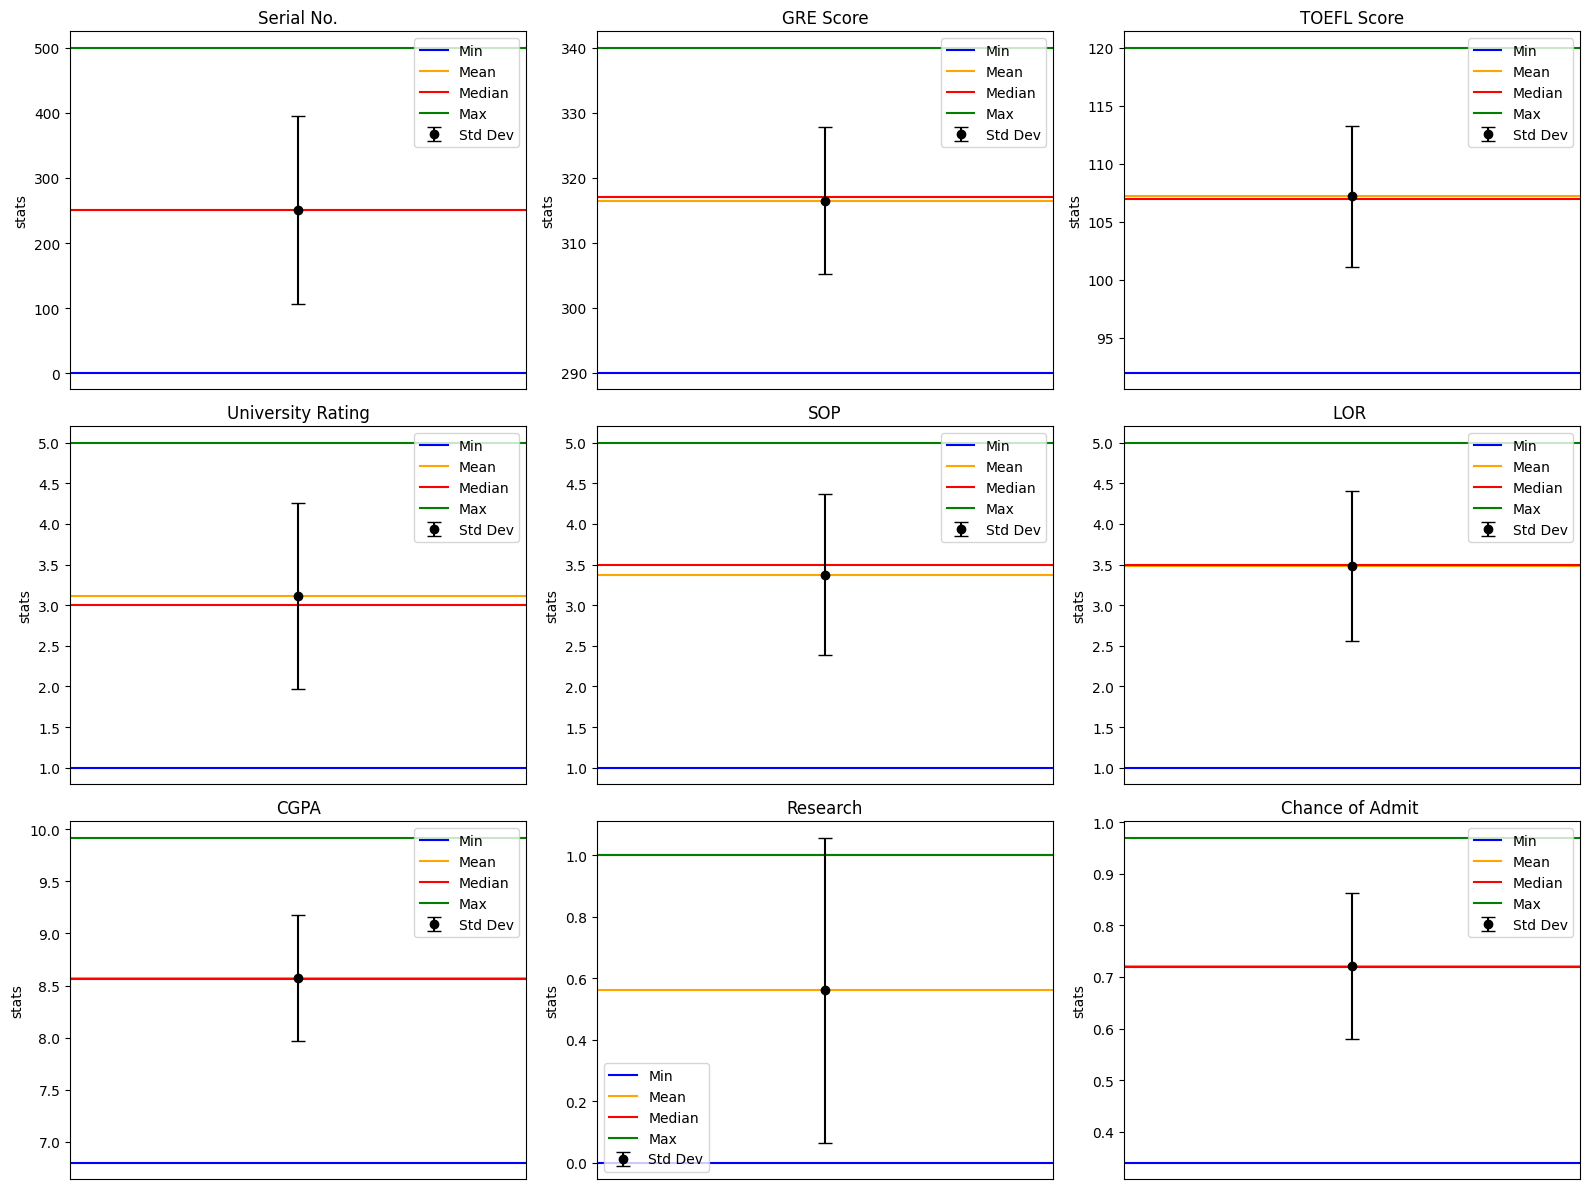

In [86]:
plt.figure(figsize=(16, 12))

n_features = len(desc_stats)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

for i, feature in enumerate(desc_stats.index):
    plt.subplot(n_rows, n_cols, i + 1)


    mean = desc_stats.loc[feature, 'mean']
    median = desc_stats.loc[feature, 'median']
    min_val = desc_stats.loc[feature, 'min']
    max_val = desc_stats.loc[feature, 'max']
    std = desc_stats.loc[feature, 'std']

    plt.axhline(y=min_val, color='blue', linestyle='-', label='Min')
    plt.axhline(y=mean, color='orange', linestyle='-', label='Mean')
    plt.axhline(y=median, color='red', linestyle='-', label='Median')
    plt.axhline(y=max_val, color='green', linestyle='-', label='Max')

    plt.errorbar(x=[0], y=[mean], yerr=[std], fmt='o', color='black', capsize=5, label='Std Dev')
    #The ends of the errorbar are 1 standard deviation away from the mean
    #The center dot of the errorbar lies on the mean line
    plt.title(feature)
    plt.ylabel('stats')
    plt.legend()
    plt.xlim(-0.5, 0.5)
    plt.gca().set_xticks([])


plt.tight_layout()
plt.show()


In [87]:
for index,column in enumerate(data.columns):
  print(f"Column {column} has {data[column].isnull().sum()} missing values ")

Column Serial No. has 0 missing values 
Column GRE Score has 0 missing values 
Column TOEFL Score has 0 missing values 
Column University Rating has 0 missing values 
Column SOP has 0 missing values 
Column LOR  has 0 missing values 
Column CGPA has 0 missing values 
Column Research has 0 missing values 
Column Chance of Admit  has 0 missing values 


So there are no missing values at all and no imputation is needed.

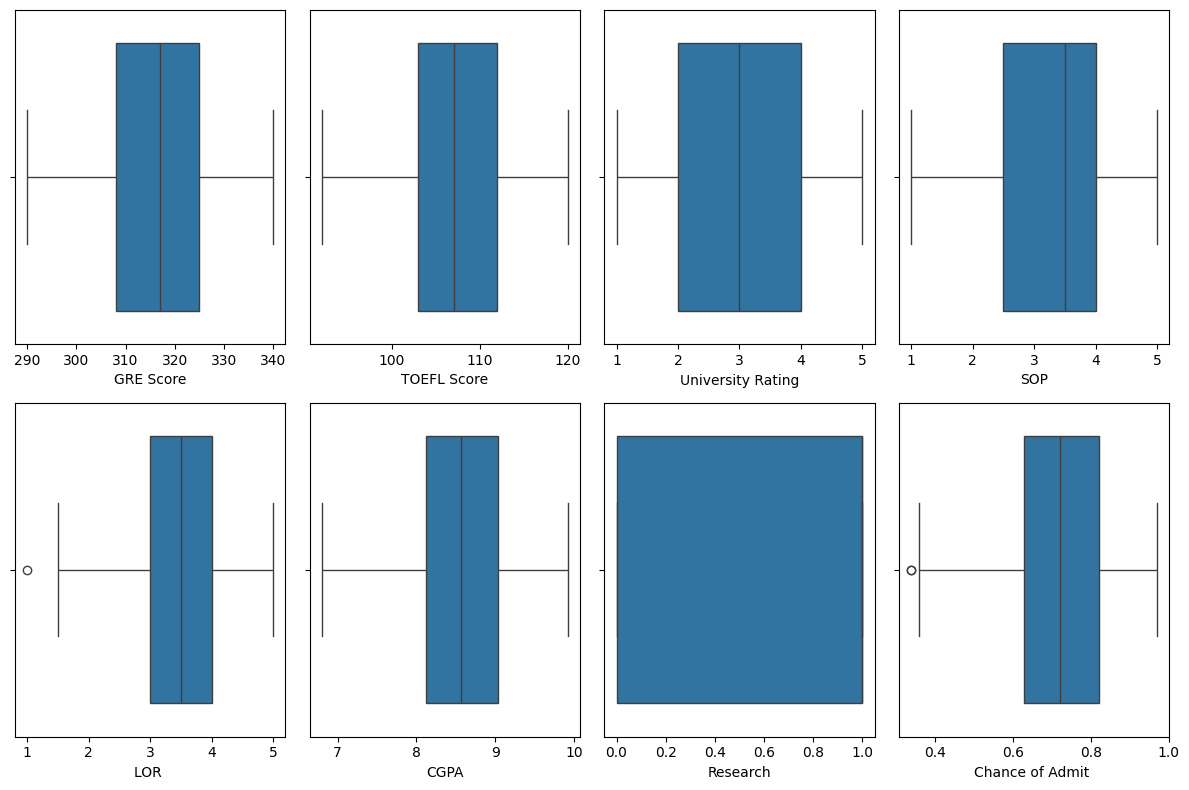

In [88]:
def plotter(data):
  plt.figure(figsize=(12, 8))
  plt.subplot(2,4,1)
  sns.boxplot(data['GRE Score'], orient='h')

  plt.subplot(2,4,2)
  sns.boxplot(data['TOEFL Score'], orient='h')

  plt.subplot(2,4,3)
  sns.boxplot(data['University Rating'], orient='h')

  plt.subplot(2,4,4)
  sns.boxplot(data['SOP'], orient='h')

  plt.subplot(2,4,5)
  sns.boxplot(data['LOR '], orient='h')

  plt.subplot(2,4,6)
  sns.boxplot(data['CGPA'], orient='h')


  plt.subplot(2,4,7)
  sns.boxplot(data['Research'], orient='h')


  plt.subplot(2,4,8)
  sns.boxplot(data['Chance of Admit '], orient='h')


  plt.tight_layout()
  plt.show()

plotter(data)


# 2. Data Scaling:
a) Select and apply an appropriate scaling technique (StandardScaler, MinMaxScaler, or RobustScaler) to normalize
the features.

b) Analyze the distribution of the features and justify your choice of scaling method.

c) Discuss how scaling impacts model performance.

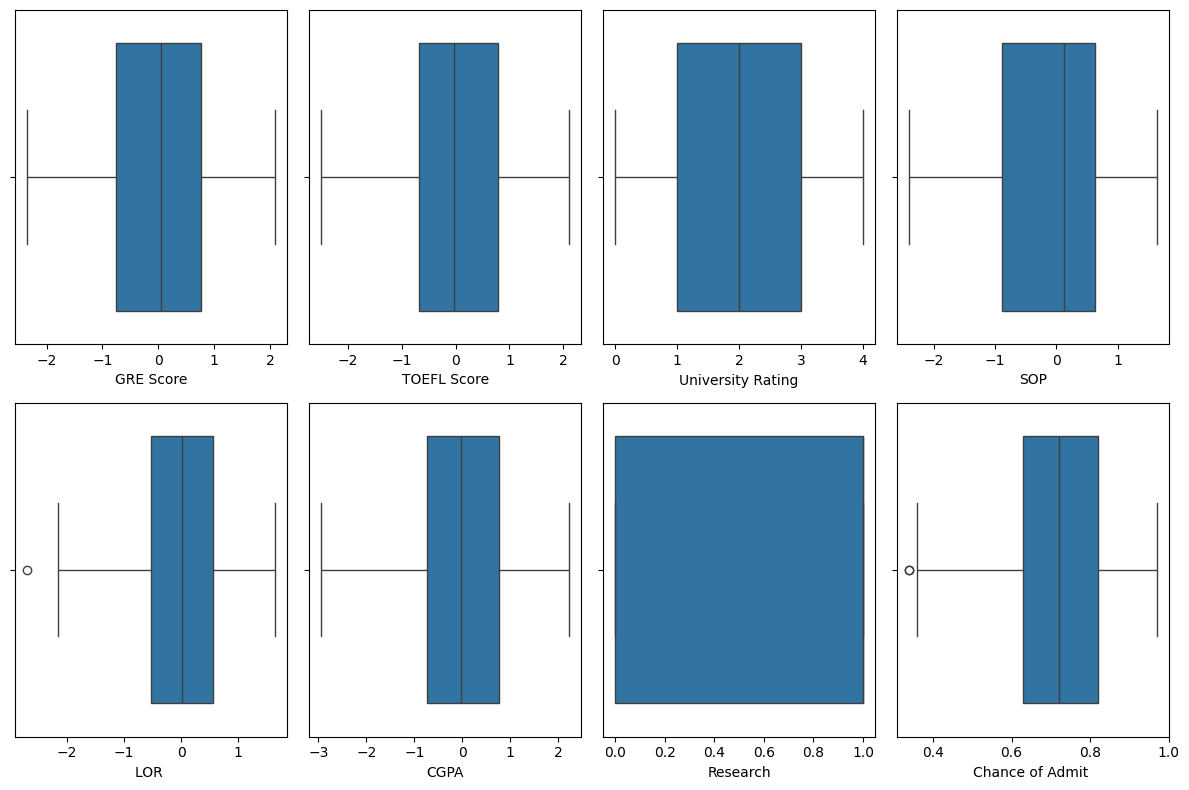

In [89]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

x = data.drop('Chance of Admit ', axis=1)
y = data['Chance of Admit ']
y_copy = data['Chance of Admit '] #FOR USING IN LINEAR REGRESSION PART LATER

numeric = ['GRE Score', 'TOEFL Score', 'SOP', 'LOR ', 'CGPA']
categorical = ['Research', 'University Rating']
all = ['GRE Score', 'TOEFL Score', 'SOP', 'LOR ', 'CGPA', 'Research', 'University Rating']

Scaler = ColumnTransformer([
    ('numerical_transformer' , StandardScaler(), numeric),
    ('categorical_transformer',OrdinalEncoder(), categorical),
    ])

scaled = Scaler.fit_transform(x)

x = pd.DataFrame(scaled, columns=all)

data = pd.concat([x, y], axis=1)
plotter(data)

Reasons for StandardScaler:

1) Since some of the features like CGPA and GRE Scores have larger magnitudes, scaling them down using StandardScaler ensures that these features don’t dominate the learning algorithms based solely on their magnitude, making it more balanced.

2) MinMaxScaler might not be appropriate here because it compresses data into a specific range, often [0,1]. If the majority of your features follow a distribution close to normal, which is the case here from the graphs, StandardScaler will be better. It preserves the shape of the data distribution, which is beneficial for models that assume normality.

Reasons for OrdinalEncoder:

1) The research and university rating features are catgorical and are not being scaled normally to prevent distorting their discrete numerical values. The university rating has 5 possible values 1,2,3,4,5 and research column has either 0 or 1.

2) Ordinal Encoding will ensure that the model interprets the "University Rating" feature correctly. It will ensure that the model understands that these numbers represent ranks. This won't change the values but will clearly indicate that they are ordinal categories.

Scaling ensures that no feature somehow influences the model more than other features due to its magnitude. Proper scaling can lead to more efficient training, better performance, and faster convergence in many algorithms.

# 3. Dimensionality Reduction with LDA:
1)  Discretize the "Chance of Admit": Convert the "Chance of Admit" variable into three categories (e.g., low,
medium, high) using an appropriate binning technique.

2)  Apply LDA: Use the categorized target variable to perform Linear Discriminant Analysis (LDA) on the input
features. LDA will reduce the dimensionality of the feature space by projecting the data into a lower-dimensional
space that maximizes class separability.

3)  Justify the choice of number of components retained after LDA, and evaluate how this dimensionality reduction
influences the dataset.

In [90]:
custom_bins = [0, 0.5, 0.8, 1]
data['Chance of Admit '] = pd.cut(data['Chance of Admit '], bins=custom_bins, labels=['low', 'medium', 'high'],include_lowest = True)
data['Chance of Admit ']
# Count the number of occurrences for each bin category
bin_counts = data['Chance of Admit '].value_counts()
# Display the counts for 'low', 'medium', and 'high'
print(bin_counts)

Chance of Admit 
medium    319
high      142
low        39
Name: count, dtype: int64


Using pd. cut, we can specify custom boundaries according to our needs.

In [91]:
x = data.drop('Chance of Admit ', axis=1)
y = data['Chance of Admit ']
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
x = lda.fit_transform(x, y)

x

array([[-2.97325991e+00,  7.68986724e-01],
       [-9.96324976e-01,  6.33891736e-02],
       [ 9.27413400e-01, -7.51943547e-01],
       [-3.63146729e-01, -1.08389515e+00],
       [ 1.35111350e+00,  1.27171132e+00],
       [-2.30041174e+00, -1.95065606e+00],
       [ 1.90031764e-01, -8.41758763e-02],
       [ 1.90097977e+00,  1.15985249e+00],
       [ 2.29020857e+00,  2.53391161e-01],
       [ 1.75396081e-01,  1.43132095e-01],
       [ 7.44996827e-02,  1.10791893e-01],
       [-1.47747652e+00,  1.65706748e-01],
       [-1.70173897e+00,  2.93379105e-01],
       [ 7.83086134e-01, -2.10664107e+00],
       [ 8.94140699e-01, -2.21781758e+00],
       [ 9.64151441e-01, -8.14049551e-01],
       [ 1.57615694e-01, -6.30108851e-02],
       [ 8.86407904e-01, -1.77735429e+00],
       [-1.97365227e-01, -5.93401635e-03],
       [ 8.73318280e-01, -1.61757995e-01],
       [ 1.12219802e+00, -2.46405867e+00],
       [-6.70927319e-02, -1.83129013e+00],
       [-2.84889355e+00, -2.16446418e-01],
       [-3.

LDA reduces the numer of features to C - 1 when C is the number of classes in the target variable. So here when our target variables has three possible classes, low,medium and high, LDA reduces our feature vector to a length of 2. The reason this is the case is that LDA creates linear combinations of the original features that maximize the between-class variance while minimizing the within-class variance. To separate C classes,  at most C - 1 linear discriminants are needed, because each additional linear discriminant is used to separate one more class.

In [92]:
x = pd.DataFrame(x, columns=['Feature 1' , 'Feature 2'])
z = pd.concat([x, y], axis=1)
z

,Feature 1,Feature 2,Chance of Admit
0,-2.973260,0.768987,high
1,-0.996325,0.063389,medium
2,0.927413,-0.751944,medium
3,-0.363147,-1.083895,medium
4,1.351113,1.271711,medium
...,...,...,...
495,-1.513781,-1.203337,high
496,-3.543162,0.449911,high
497,-3.238150,0.040305,high
498,0.332764,0.584893,medium


GRAPH FOR SEEING RESULT AFTER LDA

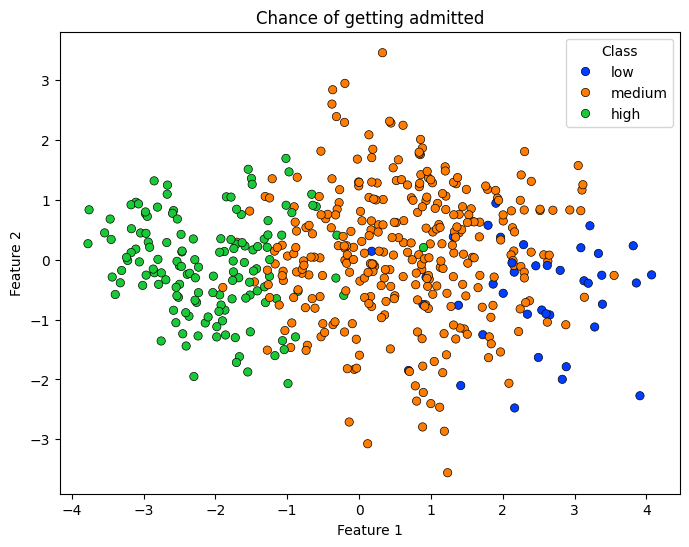

In [93]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data= z, x='Feature 1', y='Feature 2', hue='Chance of Admit ', palette='bright', edgecolor='k')

# Title and labels
plt.title('Chance of getting admitted')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Class')
plt.show()

# 4. Linear Regression on LDA Transformed Data:

1) Use the transformed features from LDA as input for linear regression to predict the original continuous "Chance of Admit" values.

2) Compare the performance of the linear regression model using two different approaches: Tensorflow and Scikit-Learn

First we split the datset into training, testing and validation sets, which will be same for both the methods.

In [94]:
from sklearn.model_selection import train_test_split

x = z.drop('Chance of Admit ', axis=1)
y = y_copy # NON DISCRETIZED COPY OF 'CHANCE OF ADMIT' LABEL

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

METHOD 1 : TENSORFLOW LINEAR REGRESSION MODEL

In [95]:
x_train_tensor = tf.constant(x_train, dtype=tf.float32)
y_train_tensor = tf.constant(y_train.values.reshape(-1,1), dtype=tf.float32)

In [96]:
w = tf.Variable([0.0, 0.0], dtype=tf.float32)
b = tf.Variable(0.0, dtype=tf.float32)
learning_rate = 0.001
epochs = 1000

def LinearRegressionmodel(x):
  return tf.tensordot(x, w,axes = 1) + b

def mseloss(y_train_tensor, y_predicted):
  return tf.reduce_mean(tf.square(y_train_tensor - y_predicted))

optimizer = tf.optimizers.SGD(learning_rate)

for epoch in range(epochs):
  with tf.GradientTape() as tape:

    #tf.GradientTape(): This is used to record all operations that involve trainable variables (w, b)
    #so that TensorFlow can automatically compute the gradients for them during backpropagation. The
    #operations performed inside the GradientTape are recorded, and gradients are calculated based on the loss.

    y_predicted = LinearRegressionmodel(x_train_tensor)
    loss = mseloss(y_train_tensor, y_predicted)
    gradients = tape.gradient(loss, [w, b])
    optimizer.apply_gradients(zip(gradients, [w, b]))

    if (epoch % 100 == 0 or epoch == 999):
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

print(f"Mean Squared Error on Training set: {loss.numpy()}")

Epoch 0, Loss: 0.5483784675598145
Epoch 100, Loss: 0.37349948287010193
Epoch 200, Loss: 0.2569041848182678
Epoch 300, Loss: 0.17891043424606323
Epoch 400, Loss: 0.12665502727031708
Epoch 500, Loss: 0.09161616861820221
Epoch 600, Loss: 0.06811174750328064
Epoch 700, Loss: 0.05234064161777496
Epoch 800, Loss: 0.04175679758191109
Epoch 900, Loss: 0.034653227776288986
Epoch 999, Loss: 0.0299238171428442
Mean Squared Error on Training set: 0.0299238171428442


In [97]:
x_test_tensor = tf.constant(x_test, dtype=tf.float32)
y_test_tensor = tf.constant(y_test.values.reshape(-1,1), dtype=tf.float32)
y_test_pred = LinearRegressionmodel(x_test_tensor)
mse = mseloss(y_test_tensor , y_test_pred)
print(f"Mean Squared Error on Test Set: {mse}")

Mean Squared Error on Test Set: 0.02758433297276497


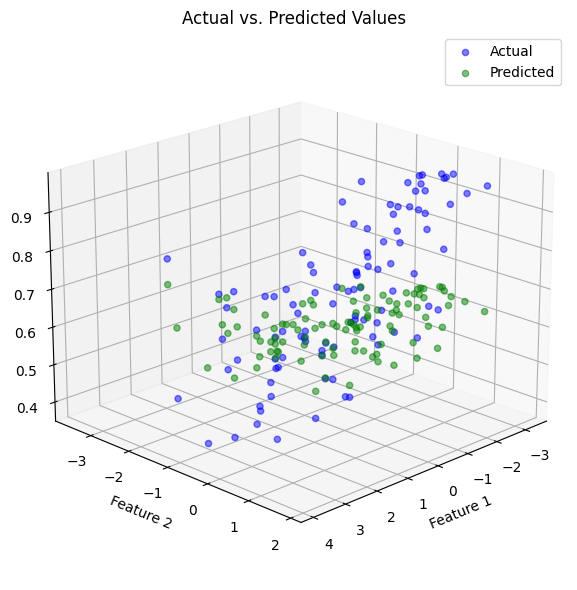

In [98]:
x1 = x_test_tensor[:, 0].numpy()
x2 = x_test_tensor[:, 1].numpy()
y_actual = y_test_tensor.numpy()
y_predicted = y_test_pred.numpy()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1, x2, y_actual, color='blue', label='Actual', alpha=0.5)

ax.scatter(x1, x2, y_predicted, color='green', label='Predicted', alpha=0.5)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Output Feature')
ax.set_title('Actual vs. Predicted Values')
ax.legend()
ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()

METHOD 2 : SCIKIT LEARN LINEAR REGRESSION MODEL

In [99]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)
msetrain = np.mean((model.predict(x_train) - y_train) ** 2)
print(f"Mean Squared Error on Training Set: {msetrain}")
y_pred = model.predict(x_test)
msetest = np.mean((y_pred - y_test) ** 2)
print(f"Mean Squared Error on Test Set: {msetest}")

Mean Squared Error on Training Set: 0.003981479202420424
Mean Squared Error on Test Set: 0.003442314557891693


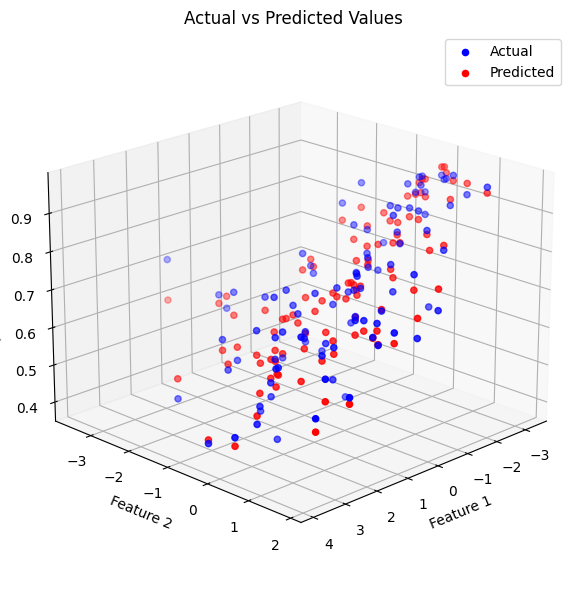

In [100]:
x_test_np = x_test.to_numpy()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_test_np[:, 0], x_test_np[:, 1], y_test, color='blue', label='Actual')
ax.scatter(x_test_np[:, 0], x_test_np[:, 1], y_pred, color='red', label='Predicted')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target Label')
ax.set_title('Actual vs Predicted Values')

ax.legend()
ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()

Below is a combined plot comparing the predictions of both methods.

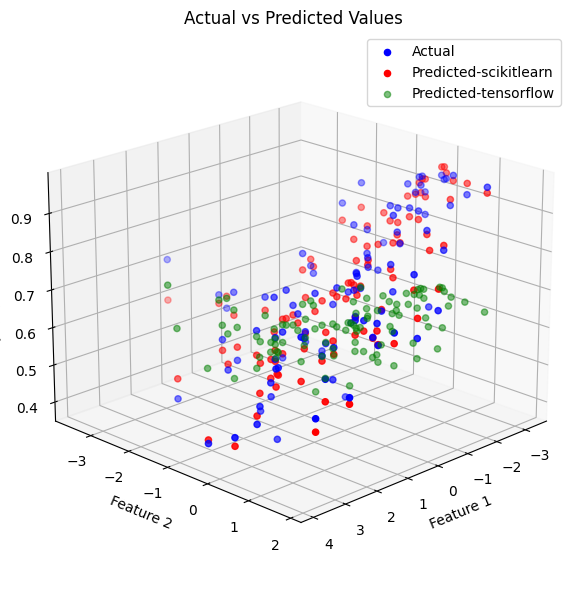

In [101]:
x_test_np = x_test.to_numpy()
x1 = x_test_tensor[:, 0].numpy()
x2 = x_test_tensor[:, 1].numpy()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_test_np[:, 0], x_test_np[:, 1], y_test, color='blue', label='Actual')
ax.scatter(x_test_np[:, 0], x_test_np[:, 1], y_pred, color='red', label='Predicted-scikitlearn')
ax.scatter(x1, x2, y_predicted, color='green', label='Predicted-tensorflow', alpha=0.5)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target Label')
ax.set_title('Actual vs Predicted Values')

ax.legend()
ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()

Based on both training and testing losses the scikit-learn predefined model does better.
Even looking at the plots we can see how much better the scikit-learn model does.

Scikit learn LinearRegression model uses the Ordinary Least Squares method to find optimal weights. In this, the model uses a matrix method to determine optimal solution directly instead of doing a gradient descent where the weights improve over time.

The problem with OLS method is when there are too many features the matrix computations in it become very  computationally expensive. So for smaller datasets as ours here, scikit learn model outperforms tensorflow model. But when there is a large dataset, manually defined models which give more control to the operator should be preferred.


# 5. Logistic Regression:
1) Convert the "Chance of Admit" into three categories (low, medium, and high) using an appropriate binning
technique.

2)Implement logistic regression to predict the categorized admission chances using TensorFlow:

a) Build the model using TensorFlow and use the Softmax activation function for multi-class classification.

b) Tune the learning rate to optimize performance, evaluating the impact of different values.

c) Compare the performance of logistic regression with other models like Random Forest (implemented in the
previous Assignment), focusing on metrics such as accuracy, precision, recall, F1-score, and AUC-ROC.

In [102]:
x_logistic = data.drop('Chance of Admit ',axis = 1)
y_logistic = data['Chance of Admit ']

In [103]:
x_train_logistic, x_test_logistic, y_train_logistic, y_test_logistic = train_test_split(x_logistic, y_logistic, test_size=0.2, random_state=42)

In [104]:
x_train_logistic_lda = lda.fit_transform(x_train_logistic,y_train_logistic)

In [105]:

label_mapping = {'low': 0, 'medium': 1, 'high': 2}

y_train_encoded = pd.Series(y_train_logistic).map(label_mapping).values

In [106]:
y_train_encoded = pd.DataFrame(y_train_encoded)

In [107]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(x_train_logistic_lda.shape[1],)),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [108]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [109]:
y_train_encoded_int = y_train_encoded.astype('int')
history = model.fit(x_train_logistic_lda, y_train_encoded_int, epochs=100, batch_size=32, verbose=0)

In [110]:
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]

print(f"Final Loss after 100 epochs: {final_loss}")
print(f"Final Accuracy after 100 epochs: {final_accuracy}")

Final Loss after 100 epochs: 0.4801938235759735
Final Accuracy after 100 epochs: 0.8450000286102295


In [111]:

label_mapping = {'low': 0, 'medium': 1, 'high': 2}
y_test_encoded = pd.Series(y_test_logistic).map(label_mapping).values

In [112]:
x_test_logistic_lda = lda.fit_transform(x_test_logistic,y_test_logistic)
y_test_encoded_int = y_test_encoded.astype('int')

Random Forest Model to compare with the Logistic Regression Model

In [113]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
y_train_encoded_int = y_train_encoded_int.values.ravel()
rf_model.fit(x_train_logistic_lda,y_train_encoded_int)

RandomForestClassifier(random_state=42)

In [114]:

y_test_pred_proba = model.predict(x_test_logistic_lda)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

test_recall = recall_score(y_test_encoded_int, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_encoded_int, y_test_pred, average='weighted')

test_precision = precision_score(y_test_encoded_int, y_test_pred, average='weighted')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [115]:
y_pred = rf_model.predict(x_test_logistic_lda)
print(f"Logistic regression accuracy is : {final_accuracy}")
accuracy = accuracy_score(y_test_encoded_int, y_pred)
print(f"Random Forest accuracy is : {accuracy}")
print(f"Logistic Regression precision is : {test_precision}")
precision = precision_score(y_test_encoded_int, y_pred, average='weighted')
print(f"Random Forest precision is : {precision}")
print(f"Logistic Regression recall is : {test_recall}")
recall = recall_score(y_test_encoded_int, y_pred, average='weighted')
print(f"Random Forest recall is : {recall}")
print(f"Logistic Regression F1 score is : {test_f1}")
f1 = f1_score(y_test_encoded_int, y_pred, average='weighted')
print(f"Random Forest F1 score is : {f1}")

Logistic regression accuracy is : 0.8450000286102295
Random Forest accuracy is : 0.9
Logistic Regression precision is : 0.7831066176470588
Random Forest precision is : 0.899
Logistic Regression recall is : 0.86
Random Forest recall is : 0.9
Logistic Regression F1 score is : 0.8192398561890087
Random Forest F1 score is : 0.8963157894736843


#6. Hyperparameter Tuning:
1) Explore different learning rates for the models and assess their impact on convergence speed, accuracy, and loss.

2) Use techniques like grid search or random search for tuning other hyperparameters (e.g., regularization strength).

In [116]:
import numpy as np
import tensorflow as tf
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import RandomizedSearchCV

num_samples = 30
num_features = 2
x_train_tensor = tf.random.normal((num_samples, num_features))
y_train_tensor = tf.reduce_sum(x_train_tensor, axis=1) + tf.random.normal((num_samples,))


class TensorFlowLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.001, epochs=500):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.w = tf.Variable(tf.zeros((num_features,)), dtype=tf.float32)
        self.b = tf.Variable(0.0, dtype=tf.float32)

    def fit(self, X, y):
        optimizer = tf.optimizers.SGD(self.learning_rate)
        for epoch in range(self.epochs):
            with tf.GradientTape() as tape:
                y_predicted = self.predict(X)
                loss = tf.reduce_mean(tf.square(y - y_predicted))
            gradients = tape.gradient(loss, [self.w, self.b])
            optimizer.apply_gradients(zip(gradients, [self.w, self.b]))


            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss.numpy()}")
        return self

    def predict(self, X):
        return tf.tensordot(X, self.w, axes=1) + self.b

    def score(self, X, y):
        y_predicted = self.predict(X)
        return -tf.reduce_mean(tf.square(y - y_predicted)).numpy()


param_dist = {
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [500, 1000, 1500]
}

random_search = RandomizedSearchCV(
    TensorFlowLinearRegression(),
    param_distributions=param_dist,
    n_iter=5,
    scoring='neg_mean_squared_error',
    cv=2,
    verbose=2,
    random_state=42
)

random_search.fit(x_train_tensor.numpy(), y_train_tensor.numpy())

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {abs(random_search.best_score_)}")

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Epoch 0, Loss: 2.6485743522644043
Epoch 100, Loss: 0.615043580532074
Epoch 200, Loss: 0.5334309339523315
Epoch 300, Loss: 0.5245517492294312
Epoch 400, Loss: 0.5234882831573486
Epoch 500, Loss: 0.5233593583106995
Epoch 600, Loss: 0.5233436822891235
Epoch 700, Loss: 0.5233417749404907
Epoch 800, Loss: 0.5233415365219116
Epoch 900, Loss: 0.5233414769172668
Epoch 1000, Loss: 0.5233414173126221
Epoch 1100, Loss: 0.5233415365219116
Epoch 1200, Loss: 0.5233414769172668
Epoch 1300, Loss: 0.5233414769172668
Epoch 1400, Loss: 0.5233414769172668
[CV] END ....................epochs=1500, learning_rate=0.01; total time=   8.2s
Epoch 0, Loss: 2.433993339538574
Epoch 100, Loss: 1.5685336589813232
Epoch 200, Loss: 1.4425429105758667
Epoch 300, Loss: 1.396301507949829
Epoch 400, Loss: 1.3777648210525513
Epoch 500, Loss: 1.3702399730682373
Epoch 600, Loss: 1.367179036140442
Epoch 700, Loss: 1.3659330606460571
Epoch 800, Loss: 1.365426421165466

In [117]:

from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

def create_model(learning_rate=0.01, regularization=0.01):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(x_train.shape[1],)),
        tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(regularization))
    ])


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

keras_model = KerasClassifier(model=create_model, epochs=20, batch_size=32, verbose=0)


random_search = RandomizedSearchCV(estimator=keras_model,
                                   param_distributions=param_distributions,
                                   n_iter=5,
                                   scoring='accuracy',
                                   cv=2,
                                   verbose=2)


random_search.fit(x_train_logistic_lda, y_train_encoded_int)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END batch_size=16, epochs=50, model__learning_rate=0.1, model__regularization=0.001; total time=   3.6s
[CV] END batch_size=16, epochs=50, model__learning_rate=0.1, model__regularization=0.001; total time=   3.5s
[CV] END batch_size=16, epochs=100, model__learning_rate=0.001, model__regularization=0.001; total time=   5.5s
[CV] END batch_size=16, epochs=100, model__learning_rate=0.001, model__regularization=0.001; total time=   6.0s
[CV] END batch_size=16, epochs=100, model__learning_rate=0.001, model__regularization=0.1; total time=   5.6s
[CV] END batch_size=16, epochs=100, model__learning_rate=0.001, model__regularization=0.1; total time=   6.2s
[CV] END batch_size=16, epochs=50, model__learning_rate=0.01, model__regularization=0.01; total time=   2.8s
[CV] END batch_size=16, epochs=50, model__learning_rate=0.01, model__regularization=0.01; total time=   2.7s
[CV] END batch_size=32, epochs=100, model__learning_rate=0.0

#7. Model Evaluation:
1) Use k-fold cross-validation to evaluate the generalization of your models.

2) Report model performance metrics including accuracy, precision, recall, F1-score, and AUC-ROC.


In [118]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

num_samples = 100
num_features = 2
x_train_tensor = tf.random.normal((num_samples, num_features))
y_train_tensor = tf.reduce_sum(x_train_tensor, axis=1) + tf.random.normal((num_samples,))

class TensorFlowLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.001, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.w = tf.Variable(tf.zeros((num_features,)), dtype=tf.float32)
        self.b = tf.Variable(0.0, dtype=tf.float32)

    def fit(self, X, y):
        optimizer = tf.optimizers.SGD(self.learning_rate)
        for epoch in range(self.epochs):
            with tf.GradientTape() as tape:
                y_predicted = self.predict(X)
                loss = tf.reduce_mean(tf.square(y - y_predicted))
            gradients = tape.gradient(loss, [self.w, self.b])
            optimizer.apply_gradients(zip(gradients, [self.w, self.b]))
        return self

    def predict(self, X):
        return tf.tensordot(X, self.w, axes=1) + self.b

    def score(self, X, y):
        y_predicted = self.predict(X)
        return -tf.reduce_mean(tf.square(y - y_predicted)).numpy()

x_train_numpy = x_train_tensor.numpy()
y_train_numpy = y_train_tensor.numpy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

tf_linear_model = TensorFlowLinearRegression()

cv_scores = cross_val_score(tf_linear_model, x_train_numpy, y_train_numpy, cv=kf, scoring='neg_mean_squared_error')

print(f"Cross-Validation Scores: {-cv_scores}")
print(f"Mean Cross-Validation Score: {-np.mean(cv_scores)}")
print(f"Standard Deviation of Cross-Validation Scores: {np.std(-cv_scores)}")

Cross-Validation Scores: [0.97553241 1.06726623 1.15304661 1.01490927 0.68617779]
Mean Cross-Validation Score: 0.9793864607810974
Standard Deviation of Cross-Validation Scores: 0.1581952893285922


In [119]:

y_train_encoded_int = y_train_encoded_int.astype(int)
y_test_encoded_int = y_test_encoded_int.astype(int)


def create_model(learning_rate=0.01, regularization=0.01):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(x_train_logistic_lda.shape[1],)),
        tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(regularization))
    ])


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
keras_model = KerasClassifier(model=create_model, epochs=50, batch_size=32, verbose=0)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(keras_model, x_train_logistic_lda, y_train_encoded_int, cv=kf, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(cv_scores)}")
print(f"Standard Deviation of Cross-Validation Scores: {np.std(cv_scores)}")

Cross-Validation Scores: [0.9    0.8375 0.8125 0.8875 0.9   ]
Mean Cross-Validation Score: 0.8675
Standard Deviation of Cross-Validation Scores: 0.035881750236018306
